# ATWR Progression
This script uses data from the OpenPowerlifting project (https://www.openpowerlifting.org). <br>
You may download a copy of the data at https://gitlab.com/openpowerlifting/opl-data.

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from datetime import date
import matplotlib.ticker as ticker

%matplotlib inline

In [19]:
data_types = {
              'Name': str,
              'Sex': str,
              'Event': str,
              'Equipment': str,
              'WeightClassKg': str,
              'BodyweightKg': float,
              'Tested': str,
              'Best3SquatKg': float,
              'Best3BenchKg': float,
              'Best3DeadliftKg': float,
              'Squat4Kg': float,
              'Bench4Kg': float,
              'Deadlift4Kg': float,
              'TotalKg': float,
              'Date': str,
              'Place': str
             }

opl = pd.read_csv('openpowerlifting.csv', dtype=data_types, usecols=list(data_types))

In [20]:
opl.rename(columns={'TotalKg':'Total'}, inplace=True)

In [21]:
opl['Tested'].fillna('No', inplace=True)

In [22]:
opl['Date'] = pd.to_datetime(opl['Date'])

In [23]:
opl['Squat'] = opl[['Best3SquatKg', 'Squat4Kg']].max(axis=1)
opl['Bench'] = opl[['Best3BenchKg', 'Bench4Kg']].max(axis=1)
opl['Deadlift'] = opl[['Best3DeadliftKg', 'Deadlift4Kg']].max(axis=1)

### Parameters
**Weight classes**: 44, 48, 52, 56, 60, 67.5, 75, 82.5, 90, 90+, 100, 110, 125, 140, 140+ <br>
**Event**: For squat, bench, and deadlift records, SBD means full-power. S, B, or D means all events.<br>
**Tested**: Use 'Yes' for tested and both 'Yes' and 'No' for untested.<br>
**Equipment**: Raw, Wraps, Single-ply, Multi-ply.<br>
**Record type**: Total, Squat, Bench, or Deadlift.

In [24]:
bw_range_low = 90
# use bw_range_high = 999 for SHW (NOTE: BodyweightKg may be blank for some SHW lifters)
bw_range_high = 100
sex = 'M'
equipment = ['Raw']
event = 'SBD'
tested = ['Yes', 'No']
record_type = 'Squat'

In [25]:
# check for errors

if record_type == 'Total' and event != 'SBD':
    raise Exception(f'You can\'t combine record_type \'Total\' and event \'{event}\'.')

if (record_type != 'Total' and record_type[0] not in event):
    raise Exception(f'You can\'t combine record_type \'{record_type}\' and event \'{event}\'.') 

In [26]:
parameter_mask = (
                  (opl['BodyweightKg'] > bw_range_low)
                  & (opl['BodyweightKg'] <= bw_range_high)
                  & (opl['Sex'] == sex)
                  & (opl['Tested'].isin(tested))
                  & (opl['Event'].str.contains(event))
                  & (opl['Equipment'].isin(equipment))
                  & (~ opl['Place'].isin(['DQ', 'DD', 'NS']))
                 )

opl_filtered = opl[parameter_mask].sort_values(by=['Date'])

In [27]:
# keep a running max of the record
opl_filtered['Record (kg)'] = opl_filtered[record_type].expanding().max()

In [28]:
# keep only the earliest date for each record
record_evolution = opl_filtered.groupby('Record (kg)', as_index=False).agg({'Name': 'first','Date': 'min', 'Event': 'first', 'Equipment': 'first'})

In [29]:
# keep only the largest value for results from the same day
record_evolution.drop_duplicates(subset='Date', keep='last', inplace=True, ignore_index=True)

In [30]:
record_evolution

,Record (kg),Name,Date,Event,Equipment
0,290.30,Bob Gaynor,1973-09-08,SBD,Raw
1,294.84,Henry Gerard,1997-02-08,SBD,Raw
2,319.78,Sam Byrd,2006-05-06,SBD,Raw
3,330.00,Andrey Kisel,2009-10-01,SBD,Raw
4,331.12,Jesse Kellum,2010-09-11,SBD,Raw
5,333.39,Jesse Kellum,2011-11-12,SBD,Raw
6,355.00,Sam Byrd,2012-01-21,SBD,Raw
7,355.50,Dan Green,2014-02-07,SBD,Raw
8,356.07,Jordan Wong,2015-05-30,SBD,Raw
9,372.50,Amit Sapir,2015-11-14,SBD,Raw


In [31]:
record_table = record_evolution[['Date', 'Name', 'Record (kg)']].copy()
record_table['Date'] = record_table['Date'].dt.strftime('%Y-%m-%d')
record_table['Name'] = record_evolution['Name'].str.replace(r' #\d', '')
record_table['Record (lb)'] = record_table['Record (kg)'].apply(lambda x: x*2.20462).round(1)

# round kgs to one decimal since some lifts were done in pounds
record_table['Record (kg)'] = record_table['Record (kg)'].round(decimals=1)

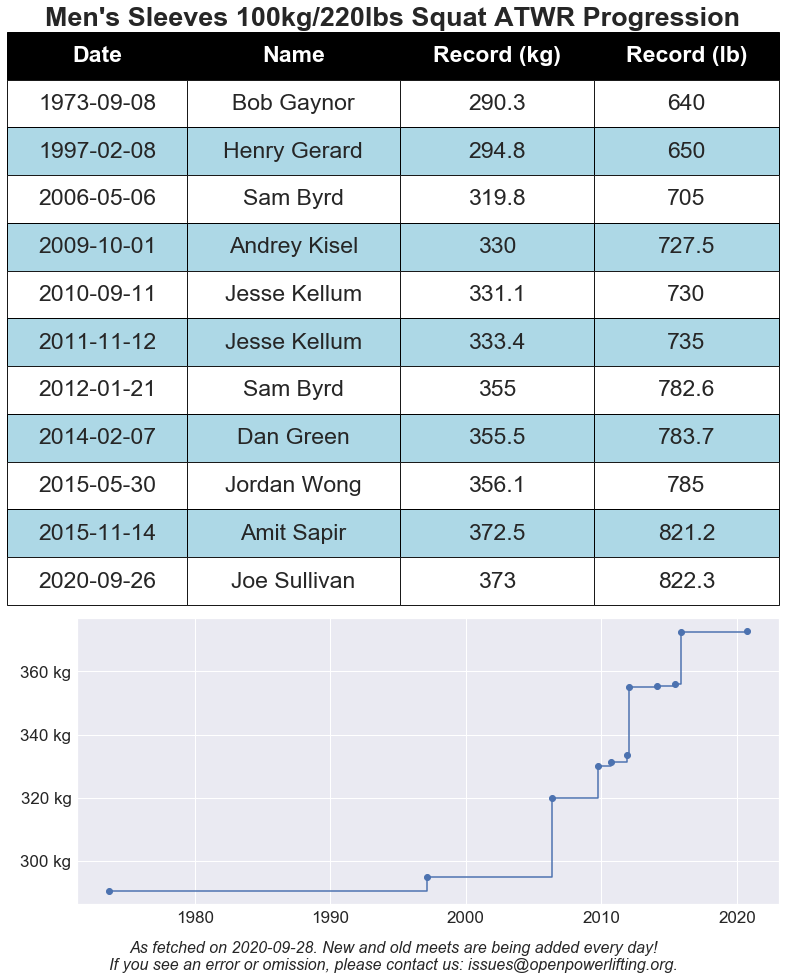

In [33]:
sns.set()

fig = plt.figure(constrained_layout=True)

grid = gridspec.GridSpec(ncols=100, nrows=3, figure=fig)

plot_1 = fig.add_subplot(grid[:2, :])
plot_2 = fig.add_subplot(grid[2, 1:]) # this makes the final product look centered

grid.update(hspace=0.05) # vertical space between subplots

# TABLE
my_table = plot_1.table(cellText=record_table.astype(str).replace('\.0$', '', regex=True).values, 
                        colLabels=record_table.columns, 
                        cellLoc='center', 
                        bbox=[0, 0, 1, 1])

my_table.auto_set_font_size(False)
my_table.set_fontsize(23) # adjust as needed (20 is usually good)
my_table.auto_set_column_width(col=[0, 1, 2, 3])

for (row, col), cell in my_table.get_celld().items():
    if (row == 0):
        cell.set_color('black')
        cell.set_text_props(color='white', fontweight='bold')

for (row, col), cell in my_table.get_celld().items():
    if (row % 2 == False and row != 0):
        cell.set_color('lightblue')
        cell.set_edgecolor('black')
        
plot_1.axis('off')

# STEP CHART
plot_2.plot_date(record_evolution['Date'], record_evolution['Record (kg)'], linestyle='-', drawstyle='steps-post')
plt.tick_params(axis='both', which='major', pad=0)
plot_2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d kg'))
plt.yticks(size=17)
plt.xticks(size=17)

# MAIN TITLE
if 'Yes' in tested and len(tested) == 1:
    is_tested = ' (Tested)'
else:
    is_tested = ''

if bw_range_high == 999:
    bw_range_high = 'SHW'
    
if event == 'SBD' and record_type != 'Total':
    single_lift = ' (Full Power)'
elif record_type != 'Total':
    single_lift = ' (All Events)'
else:
    single_lift = ''
    
# chart_title = f'{bw_range_high} {sex} {" + ".join(equipment)} {record_type} ATWR Progression' + is_tested + single_lift
chart_title = 'Men\'s Sleeves 100kg/220lbs Squat ATWR Progression'

plot_1.set_title(chart_title, fontsize=27, fontweight='bold')

# OPL DISCLAIMER
disclaimer_1 = f'As fetched on {date.today()}. New and old meets are being added every day!'
disclaimer_2 = 'If you see an error or omission, please contact us: issues@openpowerlifting.org.'

plot_2.set_xlabel(disclaimer_1 + '\n' + disclaimer_2, fontsize=16, fontstyle='italic')

plot_2.xaxis.set_label_coords(0.45, -0.125) # roughly center the disclaimer under the table

fig.set_size_inches(10.8, 13.5) # resize figure to IG dimensions (1080 x 1350)

# plt.savefig(chart_title.replace('.', ','), bbox_inches='tight')
# plt.savefig('Joe Sullivan ATWR', bbox_inches='tight')

plt.show()